In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy import constants
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
import math
import re
from scipy.optimize import minimize

# Define force field

In [2]:
def harmonic_PE(r, k, r0):
    """
    Computes harmonic potential energy

    Parameters:
        r: separation distance
        k: spring constant
        r0: equilibrium bond length

    Returns:
        Harmonic potential energy
    """
    return 0.5 * k * ((r-r0)**2)

def harmonic_force(r_vec, k, r0):
    """
    Computes the magnitude of the force due to the harmonic bond potential.

    Parameters:
        r_vec: displacement vector
        k: spring constant
        r0: equilibrium bond length

    Returns:
        Magnitude of the force due to the harmonic bond potential
    """
    r = np.linalg.norm(r_vec)
    r = np.clip(r, a_min=1e-12, a_max=None)
    return -k * (r-r0) * r_vec / r

well_coeff = 2**(1/6)
def repulsive_lj(r, sigma, epsilon):
    """
    Computes the repulsive Lennard-Jones potential energy.

    Parameters:
        r: separation distance
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        lj potential energy
    """
    if r < well_coeff*sigma:
        r = np.clip(r, a_min=1e-12, a_max=None)
        sixth_pow = (sigma/r) ** 6
        return 4 * epsilon * (sixth_pow**2 - sixth_pow + 1/4)
    else:
        return 0

def repulsive_lj_force(r_vec, sigma, epsilon):
    """
    Computes the force due to repulsive Lennard-Jones potential energy.

    Parameters:
        r_vec: displacement vector
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        force due to lj potential energy
    """
    r = np.linalg.norm(r_vec)
    if r < well_coeff*sigma:
        r = np.clip(r, a_min=1e-12, a_max=None)
        sixth_pow = (sigma/r) ** 6
        return -24*epsilon/r * (sixth_pow - 2*(sixth_pow**2)) * r_vec / r
    else:
        return np.zeros_like(r_vec)

def attractive_lj(r, sigma, epsilon):
    """
    Computes the attractive Lennard-Jones potential energy.

    Parameters:
        r: separation distance
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        lj potential energy
    """
    r = np.clip(r, a_min=1e-12, a_max=None)
    sixth_pow = (sigma/r) ** 6
    return 4 * epsilon * (sixth_pow**2 - sixth_pow)

def attractive_lj_force(r_vec, sigma, epsilon):
    """
    Computes the force due to attractive Lennard-Jones potential energy.

    Parameters:
        r_vec: displacement vector
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        force due to lj potential energy
    """
    r = np.linalg.norm(r_vec)
    r = np.clip(r, a_min=1e-12, a_max=None)
    sixth_pow = (sigma/r) ** 6
    return -24*epsilon/r * (sixth_pow - 2*(sixth_pow**2)) * r_vec / r

# Unit cell

In [3]:
class OrthorhombicCell():
    """
    Stores particle information in a orthorombic cell
    with periodic boundary conditions and minimum image convention
    """
    def __init__(self, a, b, c, n, masses, connectivity):
        """
        OrthorhombicCell(a, b, c, n, connectivity)

        Parameters:
            a, b, c: parameters of the cell
            n: number of particles in the cell
            masses: masses of particles
            connectivity:
                adjacency list of the bond connectivity of the particles.
                connectivity[i] is the list of indices for atoms bonded to atom i (0-based index)
        """
        self.dim = np.array([a, b, c])
        self.n = n
        self.masses = masses
        self.adj_list = connectivity
        self.positions = np.zeros((n, 3))
        self.bonded = None
        self.repulsive = None
        self.attractive = None
        # map of two-bond connectivity
        adj_list_2 = []
        for i in range(self.n):
            cur_list = []
            neighbors = self.adj_list[i]
            for neighbor in neighbors:
                for second_neighbor in self.adj_list[neighbor]:
                    if second_neighbor != i and second_neighbor not in neighbors:
                        cur_list.append(second_neighbor)
            adj_list_2.append(cur_list)
        self.adj_list_2 = adj_list_2

    def set_positions(self, positions):
        """
        Sets the positions of the atoms.

        Parameters:
            positions: np.array with shape self.n * 3
        """
        np.copyto(self.positions, positions)
    
    def wrap(self):
        """
        Wraps the particles into the cell by applying the pbc
        """
        self.positions %= self.dim

    def update_positions(self, delta_positions):
        """
        Add delta_positions to current positions and wrap in cell.

        Parameters:
            delta_positions: np.array with shape self.n * 3
        """
        self.positions += delta_positions
        self.wrap()

    def get_displacement_from_i_to_j(self, i, j):
        """
        Calculates displacement from atoms i to atom j with mic

        Parameters:
            i, j: int|array, indices of atoms

        Returns:
            An array of displacement vectors from atoms i to j under mic
        """
        r_vec = self.positions[j] - self.positions[i]
        r_mic = r_vec - self.dim*np.round(r_vec/self.dim)
        if r_mic.ndim == 1:
            r_mic = r_mic.reshape(1, -1)
        return r_mic

    def get_distances_between(self, i, j):
        """
        Calculates distance between atoms i and j with mic

        Parameters:
            i, j: int|array, indices of atoms

        Returns:
            An array of distances between atoms i and j under mic
        """
        r_mic = self.get_displacement_from_i_to_j(i, j)
        return np.linalg.norm(r_mic, axis=1)

    def unwrap(self):
        """
        Unwraps the particles onto the infinite lattice space
        by sequentially placing bonded atoms onto their closest image
        to the central atom. Implemented using depth-first search.
        """
        visited = np.zeros(self.n, dtype=bool)
        for i in range(self.n):
            if visited[i]:
                continue
            visited[i] = True
            visit_stack = [i]
            while (len(visit_stack)>0):
                cur_idx = visit_stack.pop()
                neighbors = self.adj_list[cur_idx]
                for neighbor_idx in neighbors:
                    if visited[neighbor_idx]:
                        continue
                    visit_stack.append(neighbor_idx)
                    visited[neighbor_idx] = True
                    r_vec = self.positions[neighbor_idx] - self.positions[cur_idx]
                    self.positions[neighbor_idx] -= self.dim*np.round(r_vec/self.dim)

    def inject_energy(self, bonded, repulsive, attractive):
        """
        Injects energy functions as dependencies.

        Parameters:
            bonded: calculates bonded potential energy. bonded(r)
            repulsive: calculates repulsive potential energy. repulsive(r)
            attractive: calculates attractive potential energy. attractive(r)
        """
        self.bonded = bonded
        self.repulsive = repulsive
        self.attractive = attractive

    def calc_PE_between(self, i, j, r):
        """
        Calculates potential energy between atoms i and j according to their connectivity.

        Parameters:
            i, j: integer indices of a pair of atoms
            r: distance between atoms i and j

        Returns:
            potential energy
        """
        if j == i:
            return 0 # self
        elif j in self.adj_list[i]:
            return self.bonded(r) # one bond
        elif j in self.adj_list_2[i]:
            return self.repulsive(r) # two bonds
        else:
            return self.attractive(r)

    def get_PE(self):
        """
        Gets the potential energy of the system with mic.
        """
        pe = 0
        for i in range(self.n):
            atom1 = np.array([i for _ in range(i+1, self.n)], dtype=int)
            atom2 = np.array(range(i+1, self.n), dtype=int)
            rs = self.get_distances_between(atom1, atom2)
            for j, r in zip(atom2, rs):
                pe += self.calc_PE_between(i, j, r)
        return pe

    def inject_force(self, bonded_f, repulsive_f, attractive_f):
        """
        Injects force functions as dependencies.

        Parameters:
            bonded_f: calculates bonded potential energy. bonded(r_vec)
            repulsive_f: calculates repulsive potential energy. repulsive(r_vec)
            attractive_f: calculates attractive potential energy. attractive(r_vec)
        """
        self.bonded_f = bonded_f
        self.repulsive_f = repulsive_f
        self.attractive_f = attractive_f

    def calc_force_i_on_j(self, i, j, r_vec):
        """
        Calculates the force on atom j from atom i according to their connectivity.

        Parameters:
            i, j: integer indices of a pair of atoms
            r_vec: displacement vector from atom i to j

        Returns:
            a vector of force with same shape as r_vec
        """
        if j == i: # self
            return np.zeros_like(r_vec)
        elif j in self.adj_list[i]: # one bond
            return self.bonded_f(r_vec) 
        elif j in self.adj_list_2[i]: # two bonds
            return self.repulsive_f(r_vec)
        else:
            return self.attractive_f(r_vec)

    def get_forces(self):
        """
        Gets the forces of the system in N with mic.

        Returns:
            A n*3 array of forces on each particle in the system.
        """
        forces = np.zeros_like(self.positions)
        for i in range(self.n):
            atom1 = np.array([i for _ in range(i+1, self.n)], dtype=int)
            atom2 = np.array(range(i+1, self.n), dtype=int)
            r_vecs = self.get_displacement_from_i_to_j(atom1, atom2)
            for j, r_vec in zip(atom2, r_vecs):
                f = self.calc_force_i_on_j(i, j, r_vec)
                forces[j] += f
                forces[i] -= f
                
        return forces

    def get_centroid(self):
        """
        Gets the centroid of the molecule.

        Returns:
            centroid of the molecule
        """
        return np.mean(self.positions, axis=0)

    def center_in_box(self, inplace=False):
        """
        Centers the molecule in box by first unwrapping it,
        moves its centroid to the box center, then wrap again.

        Parameters:
            inplace: if set to True, updates positions in place.

        Returns:
            Centered positions
        """
        self.unwrap()
        cent = self.get_centroid()
        box_center = self.dim / 2
        new_pos = self.positions + box_center - cent
        new_pos %= self.dim
        if inplace:
            np.copyto(self.positions, new_pos)
        return new_pos

    def plot_atoms(self, ax, center=True, size=1, title=None):
        """
        Plots the atoms in the cell.

        Parameters:
            ax: plotting axis
            center: if the molecule should be centered in the box
            size: controls the size of the sphere
            title: title of the plot
        """
        def plot_sphere(center, r):
            u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
            x = r*np.cos(u)*np.sin(v) + center[0]
            y = r*np.sin(u)*np.sin(v) + center[1]
            z = r*np.cos(v) + center[2]
            ax.plot_surface(x, y, z, alpha=0.6, color='r')

        self.wrap()
        if center:
            positions = self.center_in_box(inplace=False)
        else:
            positions = self.positions

        r = 0.03 * size * (self.dim[0]*self.dim[1]*self.dim[2])**(1/3)
        for coor in positions:
            plot_sphere(coor, r)

        for i, neighbors in enumerate(self.adj_list):
            for j in neighbors:
                if j > i:
                    xs = [positions[i, 0], positions[j, 0]]
                    ys = [positions[i, 1], positions[j, 1]]
                    zs = [positions[i, 2], positions[j, 2]]
                    ax.plot(xs, ys, zs, color='grey')  
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, self.dim[0]); ax.set_xticklabels([]); ax.set_xlabel('x')
        ax.set_ylim(0, self.dim[1]); ax.set_yticklabels([]); ax.set_ylabel('y')
        ax.set_zlim(0, self.dim[2]); ax.set_zticklabels([]); ax.set_zlabel('z')
        if title is None:
            title = "Molecular Configuration"
        ax.set_title(title)

    def write_psf(self, filename):
        """
        Writes a .psf file to the given file path.

        Parameters:
            filename: name of the output file
        """
        with open(filename, 'w') as file:
            file.write("PSF\n\n")
            file.write("       1 !NTITLE\n")
            file.write(" REMARKS coarse-grained polymer chain\n\n")

            file.write(f"{self.n:8d} !NATOM\n")
            for i, m in zip(range(1, self.n+1), self.masses):
                # index segid resid resname atomname atomtype charge mass
                file.write(
                    f"{i:8d} POLY   1 POL  CG    CG    0.000  {m:3.3f}\n"
                )
            file.write("\n")

            n_bonds = 0
            for i in range(self.n):
                for j in self.adj_list[i]:
                    if j > i:
                        n_bonds += 1
            file.write(f"{n_bonds:8d} !NBOND: bonds\n")
            n_bonds = 0
            for i in range(self.n):
                for j in self.adj_list[i]:
                    if j > i:
                        file.write(f"{i+1:8d}{i+2:8d}")
                        n_bonds += 1
                        if (n_bonds % 4 == 0):
                            file.write("\n")
            file.write("\n")

## QC

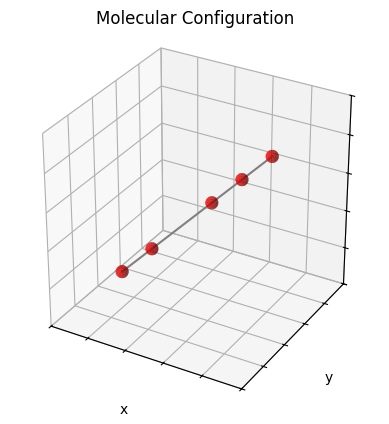

In [80]:
test = OrthorhombicCell(
    10, 10, 10, 5, [1, 1, 1, 1, 1],
    [[1],
     [0, 2],
     [1, 3],
     [2, 4],
     [3]
    ])
test.set_positions([[-1,-1,-1], [0,0,0], [2,2,2], [3,3,3], [4,4,4]])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test.plot_atoms(ax, size=1, center=True)

In [81]:
test.write_psf('topology/test.psf')

In [82]:
test.inject_energy(
    lambda r: 1,
    lambda r: 2,
    lambda r: 3
)
test.get_PE()

19

In [83]:
k = 1.0
epsilon_repulsive = 1.0

r0 = 1.0
epsilon_attractive = 0.5
sigma = 1.0
test.inject_energy(
    lambda r: harmonic_PE(r, k, r0),
    lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    lambda r: attractive_lj(r, sigma, epsilon_attractive)
)
test.get_PE()

np.float64(3.839705052771677)

# Simulation Class

In [4]:
class VelocityRescalingThermostat():
    """
    Velocity rescaling thermostat
    """
    def __init__(self, target_T, m):
        """
        VelocityRescalingThermostat(target_T, m)

        Parameters:
            target_T: target temperature
            m: array of masses of the particles
        """
        self.target_T = target_T
        self.masses = m
        self.n = m.shape[0]

    def dial_to(self, target_T):
        """
        Resets the target temperature
        
        Parameters:
            target_T: target temperature
        """
        self.target_T = target_T
    
    def __call__(self, v):
        """
        Rescales the temperature.

        Parameters:
            v: 2D array of velocities
        """
        KE = 1/2*np.sum((self.masses * (np.linalg.norm(v, axis=1)**2)))
        cur_temp = 2/3 * KE / (self.n * constants.k)
        v *= np.sqrt(self.target_T / cur_temp)

In [5]:
class MDSimulation(ABC):
    """
    Molecular Dynamics Simulation.
    """
    box = None
    timestep = None
    velocities = None
    n = 0
    masses = None
    step = 0
    rescale_interval = None
    thermostat = None
    
    def set_force_field(self, forces, potentials):
        """
        Injects force field functions.

        Parameters:
            forces: dict of force functions. f(r_vec)
            potentials: dict of potential functions. f(r)
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        """
        self.box.inject_force(forces['bonded'], forces['repulsive'], forces['attractive'])
        self.box.inject_energy(potentials['bonded'], potentials['repulsive'], potentials['attractive'])

    @abstractmethod
    def init_velocities(self, temp):
        """
        Initializes and sets the particle velocities 
        by drawing from the Maxwell-Boltzmann distribution and thermostating.
        Sets the thermostat to the provided temperature.

        Parameters:
            temp: temperature of the system
        """
        pass
        
    @abstractmethod
    def init_simulation(
        self,
        forces, potentials,
        gamma, dmd_max_steps, convergence,
        em_max_steps, force_tol, energy_tol,
        heating_n_steps, eq_n_steps
    ):
        """
        Initializes the system for simulation.

        Parameters:
            forces: dict of force functions. f(r_vec)
            potentials: dict of potential functions. f(r)
                Both must contain keys 'bonded', 'attractive' and 'repulsive'.
            gamma: dampening coefficient for velocities
            dmd_max_steps: max number of steps to run damped md
            em_max_steps: max steps to run energy minimization
            force_tol: force tolerance
            energy_tol: energy tolerance
            convergence: convergence threshold for potential difference
            heating_n_steps: number of steps to heat up the system to target temperature
            eq_n_steps: number of equilibration steps
        """
        pass
    
    def run(self):
        """
        Runs one time step of the MD simulation.
        """
        self.step += 1
        masses = self.masses.reshape(n, 1)
        
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        self.velocities += dv
        self.box.update_positions(self.velocities * self.timestep)
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        self.velocities += dv

        if self.step % self.rescale_interval == 0:
            self.thermostat(self.velocities)

    def em(self, max_steps=2000, force_tol=1e-3, energy_tol=1e-6):
        """
        Runs energy minimization.

        Parameters:
            max_steps: max steps to run
            force_tol: force tolerance
            energy_tol: energy tolerance
        """
        print("Starting energy minimization...")
        pbar = tqdm(total=None, desc="EM")
        def objective(coords):
            self.box.set_positions(coords.reshape(self.box.positions.shape))
            self.box.wrap()
            pe = self.box.get_PE()
            pbar.update(1)
            pbar.set_description(f"Potential = {pe:.2f}")
            return (pe, -self.box.get_forces().ravel())

        coords = minimize(
            objective,
            self.box.positions.ravel(),
            method='L-BFGS-B',
            jac=True,
            options = {
                'maxiter': max_steps,
                'gtol': force_tol,
                'ftol': energy_tol
            }
        )
        print(f"EM {"succeeded" if coords.success else "failed"} after {coords.nit} iterations with PE = {coords.fun:.2f}")
        self.box.set_positions(coords.x.reshape((self.n, 3)))
        self.box.wrap()

    def damped_md(self, gamma=0.5, max_steps=5000, convergence = 1e-10):
        """
        Runs damped MD energy minimization to minimize potential energy.

        parameters:
            gamma: dampening coefficient for velocities
            max_steps: max number of steps to run
            convergence: convergence threshold for potential difference
        """
        print(f"Starting damped MD on {self.n} atoms...")
        masses = self.masses.reshape(n, 1)
        self.velocities = np.zeros_like(self.box.positions)
        last_PE = self.box.get_PE()
        
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        self.velocities += dv * gamma
        self.box.update_positions(self.velocities * self.timestep)
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep * gamma
        self.velocities += dv
        cur_PE = self.box.get_PE()

        cur_step = 0
        pbar = tqdm(total=None, desc="DMD")
        while (cur_step <= max_steps and (cur_PE > last_PE or last_PE - cur_PE > convergence)):
            last_PE = cur_PE
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep
            self.velocities += dv * gamma
            self.box.update_positions(self.velocities * self.timestep)
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep * gamma
            self.velocities += dv
            cur_PE = self.box.get_PE()

            cur_step += 1
            pbar.update(1)
            pbar.set_description(f"Potential = {cur_PE:.2f}")

        if cur_step > max_steps:
            print(f"Max itr exceeded with potential difference {last_PE - cur_PE:.2f}")
        else:
            print(f"Converged after {cur_step} iterations with potential difference {last_PE - cur_PE:.2f}")

    def heat(self, heating_n_steps=5000):
        """
        Heats up the system gradually to the target temperature.

        Parameters:
            heating_n_steps: number of steps to heat up the system to target temperature
        """
        print("Heating up the system...")
        pbar = tqdm(total=heating_n_steps)
        temp_start = self.temp / heating_n_steps
        self.init_velocities(temp_start)
        masses = self.masses.reshape(n, 1)
        for temp in np.linspace(temp_start, self.temp, num=heating_n_steps):
            self.thermostat.dial_to(temp)
        
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep
            self.velocities += dv
            self.box.update_positions(self.velocities * self.timestep)
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep
            self.velocities += dv

            self.thermostat(self.velocities)
            pbar.update(1)
            pbar.set_description(f"Tempearture = {temp:.2f}")
        print(f"Finished heating, temperature = {self.temp:.2f}, PE = {self.box.get_PE():.2f}")

In [6]:
class CoarseGrainPolymerChain(MDSimulation):
    """
    Simulation for a coarse grain polymer chain.
    """
    def init_particles(self, r0):
        """
        Initalizes the particle positions.

        Parameters:
            r0 (angstrom): bond length

        Returns:
            (positions, conn)
            positions: array of initialized positions
            conn: adjacency list of particle connectivity
        """
        conn = [[] for _ in range(self.n)]
        positions = np.zeros((self.n, 3))
        positions[0] = np.array([self.a/2, self.a/2, self.a/2])
        for i in range(1, self.n):
            direction = self.rng.random(3)*2 - 1
            direction /= np.linalg.norm(direction)
            positions[i] = positions[i-1] + r0*direction
            conn[i-1].append(i)
            conn[i].append(i-1)
        return positions, conn

    def init_velocities(self, temp):
        """
        Initializes and sets the particle velocities 
        by drawing from the Maxwell-Boltzmann distribution and thermostating.

        Parameters:
            temp: temperature of the system
        """
        std = np.sqrt(constants.k * temp / self.masses[0])
        velocities = self.rng.normal(loc=0, scale=std, size=(self.n, 3))
        velocities -= np.mean(velocities, axis=0) # rid of net momentum
        self.velocities = velocities
        self.thermostat(self.velocities) # refit to target temp

    def init_box(self):
        """
        Initializes the unit cell.
        """
        positions, conn = self.init_particles(self.r0)
        self.box = self.box_class(a, a, a, n, self.masses, conn)
        self.box.set_positions(positions)
        self.box.wrap()

    def init_simulation(
        self, forces, potentials, 
        gamma=0.05, dmd_max_steps=100, convergence=1e-2, 
        em_max_steps=2000, force_tol=1e-3, energy_tol=1e-6,
        heating_n_steps=5000, eq_n_steps=5000
    ):
        self.init_box()
        self.set_force_field(forces, potentials)
        # prevent overlap
        self.damped_md(gamma=gamma, max_steps=dmd_max_steps, convergence=convergence)
        # energy minimization
        self.em(max_steps=em_max_steps, force_tol=force_tol, energy_tol=energy_tol)
        # heat up to target temperature
        self.heat(heating_n_steps=heating_n_steps)
        # equilibration
        self.thermostat.dial_to(self.temp)
        self.init_velocities(self.temp)
        self.step = 0
        print("Starting equilibration...")
        for i in tqdm(range(eq_n_steps)):
            self.run()
        print(f"Ended equilibration with PE = {self.box.get_PE():.2f}")

        self.step = 0
        print("System ready for production!")
    
    def __init__(
        self, 
        n, a, masses, r0, temp, box, timestep, 
        thermostat, rescale_interval, rng
    ):
        """
        CoarseGrainPolymerChain(n, masses, box, timestep, thermostat, rescale_interval)

        Parameters:
            n: number of particles
            a (angstrom): cubic box length
            masses (g/mol): int|array masses of particles
            r0 (angstrom): bond length of the polymer chain
            temp (K): target temperature
            box: a Cell class
            timestep (fs): simulation time step
            thermostat: a Thermostat class
            rescale_interval: number of steps to run between thermostating
            rng: random number generator
        """
        self.rng = rng
        self.n = n
        self.a = a
        self.r0 = r0
        self.masses = np.array(masses)
        if (len(self.masses.shape) == 0):
            self.masses = np.array([masses for _ in range(self.n)])
        self.timestep = timestep
        self.rescale_interval = rescale_interval
        self.temp = temp
        self.step = 0
        self.box_class = box
        self.thermostat = thermostat(temp, self.masses)

## QC

In [116]:
k = 1.0
epsilon_repulsive = 0.1

rng = np.random.default_rng(114514)
n = 30
a = 30
mass = 1
timestep = 0.01
r0 = 1.0
epsilon_attractive = 0.5
sigma = 1.0
temp = 0.1
rescale_interval = 100

chain = CoarseGrainPolymerChain(
    n=n, a=a, masses=mass, r0=r0, temp=temp, 
    box=OrthorhombicCell, timestep=timestep, 
    thermostat=VelocityRescalingThermostat,
    rescale_interval=rescale_interval, rng=rng
)

In [117]:
potentials = {
    "bonded": lambda r: harmonic_PE(r, k, r0),
    "repulsive": lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    "attractive": lambda r: attractive_lj(r, sigma, epsilon_attractive)
}
forces = {
    "bonded": lambda r_vec: harmonic_force(r_vec, k, r0),
    "attractive": lambda r_vec: repulsive_lj_force(r_vec, sigma, epsilon_repulsive),
    "repulsive": lambda r_vec: attractive_lj_force(r_vec, sigma, epsilon_attractive)
}
gamma = 0.0001
dmd_max_steps = 20
convergence = 1e-2
em_max_steps = 200
force_tol = 1e-6
energy_tol = 1e-3
heating_n_steps = 20
eq_n_steps = 20
chain.init_simulation(
    forces, potentials,
    gamma=gamma, dmd_max_steps = dmd_max_steps, convergence = convergence,
    em_max_steps=em_max_steps, force_tol=force_tol, energy_tol=energy_tol,
    heating_n_steps = heating_n_steps,
    eq_n_steps = eq_n_steps
)

Starting damped MD on 30 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 94.00
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 46 iterations with PE = -8.64
Heating up the system...


  0%|          | 0/20 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -8.67
Starting equilibration...


  0%|          | 0/20 [00:00<?, ?it/s]

Ended equilibration with PE = -9.02
System ready for production!


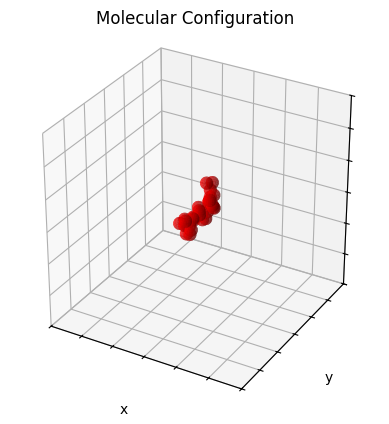

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
chain.box.plot_atoms(ax)

In [90]:
chain.box.get_PE()

np.float64(-9.016797524467334)

In [91]:
def write_traj(filename, frames):
    N = frames[0].shape[0]
    with open(filename, "w") as f:
        for pos in frames:
            f.write(f"{N}\nframe\n")
            for x, y, z in pos:
                f.write(f"CG {x:.6f} {y:.6f} {z:.6f}\n")

In [92]:
n_frames = 100
n_writes = 8
interval = n_frames//n_writes

top = "topology/chain0.psf"
traj = "trajectory/chain0.xyz"
chain.box.write_psf(top)
frames = []
for i in tqdm(range(n_frames)):
    chain.run()
    if i%interval == 0:
        frames.append(chain.box.positions.copy())
write_traj(traj, frames)

  0%|          | 0/100 [00:00<?, ?it/s]

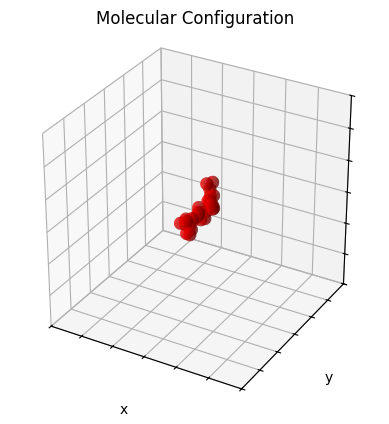

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
chain.box.plot_atoms(ax, center=True)

In [94]:
chain.box.get_PE()

np.float64(-10.602042076741917)

# Analysis Class

In [32]:
class Universe():
    """
    Universe of a simulation system.
    """
    def __init__(
        self, box, a, b, c, forces, potentials,
        top=None, traj=None, frames=None, masses=None, conn=None
    ):
        """
        Universe(box, a, b, c, forces, potentials, top, traj, positions, conn)
        Initializes the system, either with top and traj or with frames, masses and conn.

        Parameters:
            box: the unit cell class
            a, b, c: dimensions of the unit cell
            forces: dict of force functions. f(r_vec)
            potentials: dict of potential functions. f(r)
                Both must contain keys 'bonded', 'attractive' and 'repulsive'.
            
            top: path to topology file
            traj: path to trajectory file
            ----------------------------------
            frames: list of positions for each frame
            masses: masses of atoms
            conn: adjacency list of connectivity of the atoms
        """
        self.is_center = False
        self.frames = None
        self.conn = None
        self.masses = None
        self.n = 0
        self.n_frames = 0
        self.box_class = box
        self.a = a; self.b = b; self.c = c
        self.cur_step = 0
        self.forces = forces
        self.potentials = potentials
        
        if frames:
            self.frames = frames
            self.n_frames = len(frames)
            self.conn = conn
            self.masses = masses
            self.n = len(self.masses)
            self.set_step(0)
            return
        
        atoms_line = re.compile(r'(\d+)\s+!NATOM')
        atoms = re.compile(r'(\d+)\s+\w+\s+\d+\s+\w+\s+\w+\s+\w+\s+\d+.\d+\s+(\d+.\d+)')
        bonds_line = re.compile(r'(\d+)\s+!NBOND:\s+bonds')
        with open(top, 'r') as file:
            line = file.readline()
            while line:
                atoms_group = atoms_line.search(line)
                if atoms_group:
                    n_atoms = int(atoms_group.group(1))
                    self.n = n_atoms
                    self.masses = np.zeros(self.n)
                    self.conn = [[] for _ in range(self.n)]
                    for i in range(n_atoms):
                        line = file.readline()
                        atom_group = atoms.search(line)
                        idx = int(atom_group.group(1)) - 1
                        mass = float(atom_group.group(2))
                        self.masses[idx] = mass
                else:
                    bonds_group = bonds_line.search(line)
                    if bonds_group:
                        n_bonds = int(bonds_group.group(1))
                        for i in range(math.ceil(n_bonds/4)):
                            bonds = file.readline().strip().split()
                            for j in range(0, len(bonds), 2):
                                x = int(bonds[j]) - 1
                                y = int(bonds[j+1]) - 1
                                self.conn[x].append(y)
                                self.conn[y].append(x)
                line = file.readline()
        self.traj = traj
        with open(self.traj, 'r') as file:
            for line in file:
                if line.strip().lower() == 'frame':
                    self.n_frames += 1
        self.set_step(0)

    def center(self):
        """
        Centers the atoms in the unit cell.
        """
        self.is_center = True
    
    def set_step(self, i):
        """
        Sets the current positions at step i of the trajectory.
        """
        if i >= self.n_frames:
            raise ValueError(f"Index {i} out of bounds for a trajectory with {self.n_frames} frames")
        if i < 0:
            i = self.n_frames + i
        self.cur_step = i
        print(f"Trajectory at time {self.cur_step}")
        
        self.box = self.box_class(self.a, self.b, self.c, self.n, self.masses, self.conn)
        self.box.inject_force(self.forces['bonded'], self.forces['repulsive'], self.forces['attractive'])
        self.box.inject_energy(self.potentials['bonded'], self.potentials['repulsive'], self.potentials['attractive'])
        
        if self.frames:
            self.box.set_positions(self.frames[i])
            self.box.wrap()
            return
            
        pos_line = re.compile(r'\w+\s+(\d+.\d+)\s+(\d+.\d+)\s+(\d+.\d+)')
        positions = np.zeros((self.n, 3))
        with open(self.traj, 'r') as file:
            n_frames = -1
            while n_frames < i:
                line = file.readline()
                if line.strip().lower() == 'frame':
                    n_frames += 1
            for j in range(self.n):
                line = file.readline().strip()
                pos = pos_line.search(line)
                x = float(pos.group(1)); y = float(pos.group(2)); z = float(pos.group(3));
                positions[j] = np.array([x, y, z], dtype=float)
        self.box.set_positions(positions)
        if self.is_center:
            self.box.center_in_box(inplace=True)
        else:
            self.box.wrap()

    def get_center_of_mass(self):
        """
        Calculates the center of mass of the system.
        """
        masses = self.masses.reshape((self.n, 1))
        return np.mean(masses * self.box.positions, axis=0)

    def get_radius_of_gyration(self):
        """
        Calculates the radius of gyration of the system.
        """
        com = self.get_center_of_mass()
        rg = np.mean(
            np.linalg.norm(self.box.positions - com, axis=-1)**2
        )
        return rg

    def get_end_to_end_distance(self):
        """
        Calculates the end-to-end distance of the system.
        """
        return np.linalg.norm(self.box.positions[-1] - self.box.positions[0])

    def get_PE(self):
        """
        Calculates the potential energy of the system.
        """
        return self.box.get_PE()

    def plot(self, ax, center=True, size=1, title=None):
        """
        Plots the atoms in the cell.

        Parameters:
            ax: plotting axis
            center: if the molecule should be centered in the box
            size: controls the size of the sphere
            title: title of the plot
        """
        self.box.plot_atoms(ax, center, size, title)

## QC

In [33]:
u = Universe(
    OrthorhombicCell, 30, 30, 30, forces, potentials,
    "topology/chain0.psf", "trajectory/chain0.xyz"
)

Trajectory at time 0


In [34]:
u.n_frames

9

In [35]:
u.set_step(-1)
print(u.cur_step)
u.box.positions

Trajectory at time 8
8


array([[14.424216, 15.218561, 15.565457],
       [13.999335, 14.320596, 15.64471 ],
       [14.531962, 14.275807, 14.953862],
       [15.222906, 14.050904, 14.259143],
       [14.552068, 14.361422, 13.828708],
       [14.784828, 13.773309, 13.343212],
       [14.844608, 13.215021, 13.756719],
       [15.381016, 12.818336, 14.097345],
       [15.836791, 12.634254, 13.700236],
       [15.880962, 12.738612, 13.016417],
       [15.592771, 13.455745, 12.732337],
       [14.952433, 12.54087 , 12.448784],
       [13.717092, 11.923529, 11.524703],
       [12.754904, 11.322083, 10.542475],
       [11.649323, 11.178818, 10.301495],
       [11.974801, 12.116568, 10.594346],
       [13.038651, 12.399441, 10.619573],
       [14.026488, 12.710407, 10.772202],
       [14.790731, 12.438643, 11.32055 ],
       [14.043381, 12.783567, 11.911364],
       [13.769981, 12.527031, 12.734067],
       [14.182831, 11.753183, 12.499223],
       [14.617224, 10.968052, 12.618893],
       [14.240867,  9.887622, 12.4

In [114]:
print(u.get_radius_of_gyration())
print(u.get_end_to_end_distance())
print(u.get_PE())

6.774786444340977
8.018084370646207
-9.039682695586494


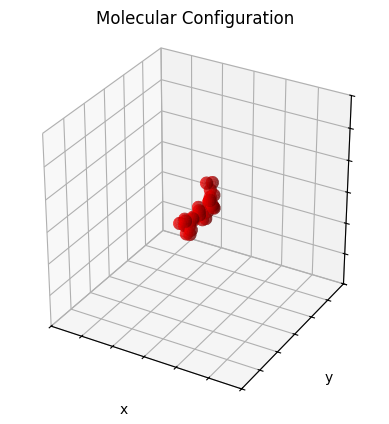

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u.plot(ax)

# Run Simulation

In [8]:
def parameterize_force_field(k, epsilon_repulsive):
    """
    Parameterize the force field.

    Parameters:
        k: spring constant
        epsilon_repulsive: repulsive LJ well depth

    Returns:
        tuple of parameterized (forces, potentials)
    """
    r0 = 1.0
    epsilon_attractive = 0.5
    sigma = 1.0
    forces = {
        "bonded": lambda r_vec: harmonic_force(r_vec, k, r0),
        "attractive": lambda r_vec: repulsive_lj_force(r_vec, sigma, epsilon_repulsive),
        "repulsive": lambda r_vec: attractive_lj_force(r_vec, sigma, epsilon_attractive)
    }
    potentials = {
        "bonded": lambda r: harmonic_PE(r, k, r0),
        "repulsive": lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
        "attractive": lambda r: attractive_lj(r, sigma, epsilon_attractive)
    }
    return forces, potentials

In [9]:
def write_traj(filename, frames):
    N = frames[0].shape[0]
    with open(filename, "w") as f:
        for pos in frames:
            f.write(f"{N}\nframe\n")
            for x, y, z in pos:
                f.write(f"CG {x:.6f} {y:.6f} {z:.6f}\n")

In [14]:
def run_md(n, a, temp, forces, potenitals, n_steps, save_interval, top, traj, rng):
    """
    Runs the MD simulation.

    Parameters:
        n: number of atoms to simulate
        a: cubic cell dimensions
        temp: simulation temperature
        forces: dict of force functions. f(r_vec)
        potentials: dict of potential functions. f(r)
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        n_steps: number of simulation steps
        save_interval: number of steps between saves. Set to None for to disable saving.
        top: path to topology file
        traj: path to trajectory file
        rng: random number generator
    """
    r0 = 1.0
    mass = 1
    timestep = 0.01
    rescale_interval = 100
    
    chain = CoarseGrainPolymerChain(
        n=n, a=a, masses=mass, r0=r0, temp=temp, 
        box=OrthorhombicCell, timestep=timestep, 
        thermostat=VelocityRescalingThermostat,
        rescale_interval=rescale_interval, rng=rng
    )
    
    gamma = 0.0001
    dmd_max_steps = 100
    convergence = 1e-2
    em_max_steps = 200
    force_tol = 1e-6
    energy_tol = 1e-3
    heating_n_steps = 500
    eq_n_steps = 500
    chain.init_simulation(
        forces, potentials,
        gamma=gamma, dmd_max_steps=dmd_max_steps, convergence=convergence,
        em_max_steps=em_max_steps, force_tol=force_tol, energy_tol=energy_tol,
        heating_n_steps=heating_n_steps,
        eq_n_steps=eq_n_steps
    )

    if save_interval is not None:
        chain.box.write_psf(top)
    frames = []
    for i in tqdm(range(n_steps)):
        chain.run()
        if save_interval is not None and i % save_interval == 0:
            frames.append(chain.box.positions.copy())
    if save_interval is not None:
        write_traj(traj, frames)

In [15]:
def scan_temperatures(temps, n, a, forces, potenitals, n_steps, save_interval, top, traj, rng):
    """
    Runs MD on each of the given temperatures

    Parameters:
        temps: list of simulation temperatures
        n: number of atoms to simulate
        a: cubic cell dimensions
        forces: dict of force functions. f(r_vec)
        potentials: dict of potential functions. f(r)
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        n_steps: number of simulation steps
        save_interval: number of steps between saves. Set to None for to disable saving.
        top: path to topology file
        traj: path to trajectory file
        rng: random number generator
    """
    top_prefix = ""
    top_postfix = ""
    traj_prefix = ""
    traj_postfix = ""
    file_name_regex = re.compile(r"^(.+)\.(.+)$")
    if save_interval is not None:
        grp = file_name_regex.match(top)
        top_prefix = grp.group(1)
        top_postfix = grp.group(2)
        grp = file_name_regex.match(traj)
        traj_prefix = grp.group(1)
        traj_postfix = grp.group(2)

    for temp in temps:
        run_md(
            n, a, temp, forces, potenitals, n_steps, save_interval,
            f"{top_prefix}_{temp}.{top_postfix}",
            f"{traj_prefix}_{temp}.{traj_postfix}",
            rng
        )

In [16]:
rng = np.random.default_rng(114514)

In [17]:
temps = np.linspace(0.1, 1.0, 6)
n = 20
a = 100
epsilon_repulsives = np.linspace(0.01, 1.0, 6)
ks = np.linspace(0.1, 2.0, 6)

for epsilon_repulsive in epsilon_repulsives:
    for k in ks:
        print(f"er = {epsilon_repulsive}, k = {k}")
        n_steps = 10000
        save_interval = 10
        forces, potentials = parameterize_force_field(k, epsilon_repulsive)
        file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er"
        scan_temperatures(
            temps, n, a, forces, potentials, n_steps, save_interval,
            f"topology/{file_prefix}.psf",
            f"trajectory/{file_prefix}.xyz",
            rng
        )

er = 0.01, k = 0.1
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -188.28
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 8 iterations with PE = 88.57
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 87.51
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 23.83
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 15.28
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 9 iterations with PE = -5.15
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -5.12
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.60
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -539.80
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 20 iterations with PE = 212.47
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = 207.27
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 77.58
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.85
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 19 iterations with PE = 10.53
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 10.89
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 4.26
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 56.54
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 13 iterations with PE = -5.40
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -5.42
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.46
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 32.22
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 7 iterations with PE = -14.33
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -14.44
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -18.06
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.01, k = 0.48
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 8.18
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 5 iterations with PE = -3.51
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -3.47
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.19
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -194.13
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 13 iterations with PE = -7.21
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -7.45
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -14.00
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1501.08
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 1 iterations with PE = 36.01
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = 4.55
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.47
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -84.91
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 36 iterations with PE = 13.26
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 13.25
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 9.45
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Exception in thread Thread-3:
Traceback (most recent call last):
  File "C:\Users\repti\anaconda3\envs\chem-4050\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "C:\Users\repti\anaconda3\envs\chem-4050\Lib\site-packages\tqdm\_monitor.py", line 69, in run
    instances = self.get_instances()
                ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\repti\anaconda3\envs\chem-4050\Lib\site-packages\tqdm\_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\repti\anaconda3\envs\chem-4050\Lib\_weakrefset.py", line 96, in copy
    return self.__class__(self)
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\repti\anaconda3\envs\chem-4050\Lib\_weakrefset.py", line 51, in __init__
    self.update(data)
  File "C:\Users\repti\anaconda3\envs\chem-4050\Lib\_weakrefset.py", line 123, in update
    for element in other:
                   ^^^^^
  File "C:\Users\repti\a

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 7.60
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 13 iterations with PE = 0.13
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 0.15
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.18
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -100.03
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 31 iterations with PE = -4.98
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -5.13
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.37
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.01, k = 0.86
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 69 iterations with potential difference 0.01
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 8 iterations with PE = -3.93
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -3.72
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.27
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 5.44
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 3 iterations with PE = -4.59
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.52
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.08
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 103.66
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 8 iterations with PE = -9.52
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -9.79
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -11.62
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 317.11
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 17 iterations with PE = -11.35
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -11.09
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.56
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -4298.92
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 20 iterations with PE = 7.22
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 7.08
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 4.02
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 251.35
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 19 iterations with PE = 5.34
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = 5.19
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.41
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.01, k = 1.2400000000000002
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 4363.35
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 15 iterations with PE = 35.28
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 27.47
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.65
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -8.56
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 21 iterations with PE = -1.19
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -1.61
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.34
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 5372.73
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 22 iterations with PE = -1.04
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -1.02
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.29
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1010.43
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 14 iterations with PE = 9.42
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 8.96
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.72
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1822.33
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 25 iterations with PE = 1.02
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 0.91
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.01
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 332.93
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 20 iterations with PE = 43.13
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = 42.64
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 10.85
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.01, k = 1.62
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.61
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 13 iterations with PE = -4.13
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -4.03
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.23
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -19.30
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 16 iterations with PE = 25.86
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 25.13
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 1.04
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 213.61
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 40 iterations with PE = -0.46
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -0.43
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.92
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 3493.16
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 15 iterations with PE = 4.33
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 4.36
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.34
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -11.91
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 10 iterations with PE = 18.41
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 15.53
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.29
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 2402.31
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 30 iterations with PE = 2.70
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = 2.39
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.37
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.01, k = 2.0
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 175.80
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 34 iterations with PE = -1.20
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -1.10
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.99
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 26 iterations with potential difference 0.01
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 2 iterations with PE = -3.11
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -2.73
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.58
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 5371.86
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 21 iterations with PE = -5.23
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -5.14
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.58
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1154.29
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 33 iterations with PE = 10.21
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 9.33
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.76
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 10.92
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 6 iterations with PE = -6.72
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -6.78
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.30
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2921.02
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -1.07
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -1.66
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.26
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.20800000000000002, k = 0.1
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 243.08
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 43 iterations with PE = -1.67
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -1.69
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.60
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.63
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 6 iterations with PE = -7.96
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -8.09
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.60
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.56
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 11 iterations with PE = -6.97
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -6.97
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.78
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -29.37
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 3 iterations with PE = 518.05
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 509.95
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 153.41
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -6.87
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 44 iterations with PE = -0.70
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -0.73
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.49
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 351.15
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 67 iterations with PE = -2.21
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -2.23
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.82
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.20800000000000002, k = 0.48
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 239.91
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 48 iterations with PE = -2.54
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -2.54
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.97
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -932.18
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 34 iterations with PE = 9.07
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 8.94
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 7.20
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1911.45
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -0.00
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -0.02
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.23
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1128.96
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 37 iterations with PE = 2.51
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 2.40
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.28
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.55
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 8 iterations with PE = -13.87
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -14.02
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -13.33
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 105.30
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 50 iterations with PE = -3.05
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -3.06
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.51
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.20800000000000002, k = 0.86
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 4748.61
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 43 iterations with PE = 0.67
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 0.54
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.32
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1657.95
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 40 iterations with PE = -1.72
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -1.71
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.49
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.87
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 17 iterations with PE = -7.55
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -7.80
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.71
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 291.06
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 52 iterations with PE = -1.40
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -1.39
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.76
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -8.31
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 39 iterations with PE = -3.44
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -3.47
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.40
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3.57
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 32 iterations with PE = -3.98
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -4.20
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.00
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.20800000000000002, k = 1.2400000000000002
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -4845.93
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 54 iterations with PE = 0.13
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 0.12
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.02
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.29
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 28 iterations with PE = -6.03
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -6.01
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.47
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 872.70
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 75 iterations with PE = -0.62
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -0.62
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.79
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.27
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 9 iterations with PE = -5.95
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -6.23
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.33
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -55.17
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 45 iterations with PE = -0.08
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -0.09
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.41
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 2.22
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 45 iterations with PE = -10.58
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -10.55
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.85
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.20800000000000002, k = 1.62
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.03
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 13 iterations with PE = -4.17
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -4.24
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.95
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -7959.80
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 36 iterations with PE = 0.41
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 0.35
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.06
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1.66
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 23 iterations with PE = -3.48
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -3.49
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.45
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -192.84
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 31 iterations with PE = -0.16
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -0.16
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.64
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 20.87
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 54 iterations with PE = -1.53
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -1.55
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.81
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1983.56
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 65 iterations with PE = -8.21
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -8.32
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.10
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.20800000000000002, k = 2.0
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1781.55
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 48 iterations with PE = -5.87
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -6.11
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.45
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.21
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 9 iterations with PE = -4.52
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.62
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.07
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 7.69
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 29 iterations with PE = -6.82
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -6.84
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.75
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 108.01
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -1.20
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -1.23
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.24
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1.91
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 20 iterations with PE = -9.13
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -9.30
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -9.81
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.15
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 8 iterations with PE = -4.98
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -4.97
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.13
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.406, k = 0.1
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 280.05
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 74 iterations with PE = -0.15
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -0.14
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.35
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 10.39
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 2 iterations with PE = 993.99
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 981.00
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 326.20
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.17
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 17 iterations with PE = -5.57
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -5.72
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.21
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.44
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 38 iterations with PE = 0.18
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 0.17
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.20
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -13.12
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 26 iterations with PE = 5.13
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 5.11
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 3.58
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 254.81
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 52 iterations with PE = -4.16
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -4.15
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.10
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.406, k = 0.48
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1583.28
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 30 iterations with PE = -2.74
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -2.82
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.96
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 650.19
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -4.03
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.08
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.34
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.39
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 30 iterations with PE = -4.17
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -4.21
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.98
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -16.96
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 43 iterations with PE = -2.29
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -2.37
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.24
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.64
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 23 iterations with PE = -7.59
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -7.66
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.32
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2872.09
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 56 iterations with PE = -1.59
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -1.58
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.64
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.406, k = 0.86
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 149.17
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 54 iterations with PE = -2.21
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -2.22
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.47
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.42
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 31 iterations with PE = -4.36
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.37
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.90
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 177.97
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 30 iterations with PE = -0.61
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -0.74
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.34
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 0 iterations with potential difference 0.00
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 11 iterations with PE = -4.44
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -4.45
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.93
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.25
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 27 iterations with PE = -6.52
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -6.51
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.00
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -618.51
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 62 iterations with PE = -2.48
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -2.51
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.87
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.406, k = 1.2400000000000002
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.16
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 24 iterations with PE = -4.52
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -4.55
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.39
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.54
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 11 iterations with PE = -8.48
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -8.77
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.51
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1.32
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 21 iterations with PE = -5.75
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -5.78
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.66
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -299.78
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 27 iterations with PE = -0.34
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -0.39
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.95
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.48
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 18 iterations with PE = -2.65
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -2.67
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.82
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 3630.36
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -1.99
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -1.97
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.22
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.406, k = 1.62
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -457.38
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 72 iterations with PE = -3.69
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -3.68
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.15
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.56
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 22 iterations with PE = -7.62
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -7.65
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -9.13
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 37.42
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 52 iterations with PE = -5.05
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -5.10
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.75
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -10940.34
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 49 iterations with PE = 0.12
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 0.12
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.01
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 117.68
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 16 iterations with PE = -3.25
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -3.28
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.62
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 3.81
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 23 iterations with PE = -12.55
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -12.68
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -12.05
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.406, k = 2.0
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.58
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 25 iterations with PE = -4.69
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -4.73
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.51
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 6.72
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 44 iterations with PE = -4.34
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.36
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.28
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 3564.06
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 54 iterations with PE = -1.58
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -1.58
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.55
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2.02
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 33 iterations with PE = -9.78
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -9.77
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.72
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 317.13
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 41 iterations with PE = -4.57
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -4.61
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.66
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 178.81
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 30 iterations with PE = -0.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -0.72
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.95
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.6040000000000001, k = 0.1
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.15
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 27 iterations with PE = -6.88
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -6.91
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.04
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -445.90
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 41 iterations with PE = 0.67
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 0.67
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.36
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -133.68
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 22 iterations with PE = 2.32
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = 2.31
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 1.58
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 129.76
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 56 iterations with PE = -2.27
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -2.25
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.91
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -42.31
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 43 iterations with PE = -1.36
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -1.38
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.39
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -146.77
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 55 iterations with PE = -0.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -0.73
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.44
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.6040000000000001, k = 0.48
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.38
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 17 iterations with PE = -1.44
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -1.49
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.35
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 10.08
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 8 iterations with PE = 516.28
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 487.73
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 24.56
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 0 iterations with potential difference 0.00
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 10 iterations with PE = -2.09
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -2.17
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.61
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -943.59
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 35 iterations with PE = -0.15
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -0.15
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.70
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.79
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 37 iterations with PE = -6.79
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -6.87
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.84
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -29.66
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 34 iterations with PE = -1.04
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -1.21
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.60
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.6040000000000001, k = 0.86
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 3997.04
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 67 iterations with PE = -4.42
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -4.42
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.59
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 103.19
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 72 iterations with PE = -2.84
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -2.90
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.66
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -810.90
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 63 iterations with PE = -3.63
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -3.65
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.17
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3778.41
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 76 iterations with PE = -9.03
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -9.16
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.80
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -25.99
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 11 iterations with PE = -12.25
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -12.62
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -12.61
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2.45
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 9 iterations with PE = -6.82
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -6.85
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.54
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.6040000000000001, k = 1.2400000000000002
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.14
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -5.85
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -5.88
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.79
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1840.46
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 62 iterations with PE = -0.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -0.75
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.73
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -174.23
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 32 iterations with PE = -2.58
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -2.60
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.21
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -669.07
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 18 iterations with PE = 25.30
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 12.11
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.28
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3763.34
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 40 iterations with PE = -3.28
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -3.46
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.54
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 83 iterations with potential difference 0.01
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 28 iterations with PE = -8.34
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -8.48
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.77
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.6040000000000001, k = 1.62
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 3516.80
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 72 iterations with PE = -2.53
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -2.54
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.71
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1597.33
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 27 iterations with PE = -0.70
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -0.73
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.68
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -10898.08
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = 0.14
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = 0.10
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.19
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -22.66
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 90 iterations with PE = -4.44
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -4.46
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.69
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 8998.76
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 52 iterations with PE = -6.69
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -6.71
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.96
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 0 iterations with potential difference 0.00
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 18 iterations with PE = -2.70
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -2.69
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.41
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.6040000000000001, k = 2.0
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -285.08
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 43 iterations with PE = -0.29
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -0.40
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.40
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -36.38
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 40 iterations with PE = -6.24
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -6.33
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.21
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.35
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 16 iterations with PE = -11.22
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -11.23
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -9.88
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1303.47
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 58 iterations with PE = -0.17
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -0.18
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.25
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 115.47
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 53 iterations with PE = -0.12
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -0.12
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.12
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 13.23
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 17 iterations with PE = -6.06
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -6.28
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.13
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.802, k = 0.1
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -414.65
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 20 iterations with PE = 0.96
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 0.96
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.93
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 4.53
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 11 iterations with PE = -2.09
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -2.10
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.31
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.81
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 29 iterations with PE = -7.46
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -7.49
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -9.39
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 453.51
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 26 iterations with PE = 8.92
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 8.84
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 4.20
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -63.15
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 20 iterations with PE = 6.51
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 5.89
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 2.33
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 6.55
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 55 iterations with PE = -2.50
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -2.48
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.78
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.802, k = 0.48
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2380.70
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 44 iterations with PE = 0.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 0.65
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.01
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -70.82
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 81 iterations with PE = -3.69
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -3.72
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.79
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -154.12
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 82 iterations with PE = -1.93
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -1.92
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.78
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -1.25
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 46 iterations with PE = -3.33
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -3.37
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.35
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 31.65
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 16 iterations with PE = -7.18
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -7.49
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -12.12
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -919.46
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 58 iterations with PE = -10.45
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -10.48
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -10.93
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.802, k = 0.86
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -567.13
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 32 iterations with PE = -0.90
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -0.99
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.71
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3600.31
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 51 iterations with PE = -4.68
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.72
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.60
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1520.99
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 51 iterations with PE = 0.12
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = 0.09
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.10
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2088.71
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 56 iterations with PE = -1.26
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -1.26
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.40
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -33.08
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 9 iterations with PE = 82.72
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 78.08
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.74
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -842.34
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 43 iterations with PE = -0.08
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -0.10
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.35
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.802, k = 1.2400000000000002
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -53.49
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 59 iterations with PE = -2.24
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -2.24
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.34
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -9.27
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 49 iterations with PE = -3.57
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -3.64
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.30
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 5938.99
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 58 iterations with PE = -1.41
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -1.40
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.02
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -27.28
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 37 iterations with PE = -4.12
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -4.11
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.27
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3.01
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 31 iterations with PE = -7.99
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -8.02
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -7.99
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3.74
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 38 iterations with PE = -3.65
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -3.69
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.76
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.802, k = 1.62
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.73
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 6 iterations with PE = -3.07
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -3.17
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.21
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1419.16
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 42 iterations with PE = -0.01
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 0.00
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.22
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 2516.93
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 68 iterations with PE = -4.76
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -4.81
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.38
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.76
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 41 iterations with PE = -10.30
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -10.33
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -9.98
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -19.11
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 62 iterations with PE = -4.15
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -4.16
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.16
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2.12
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 23 iterations with PE = -4.77
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -4.99
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.73
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 0.802, k = 2.0
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3706.38
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 34 iterations with PE = -0.46
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -0.49
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.89
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -22.68
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 57 iterations with PE = -2.78
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -2.81
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.94
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1719.18
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 49 iterations with PE = -1.58
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -1.66
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.47
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -44.17
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 48 iterations with PE = -3.20
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -3.20
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.25
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1670.16
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 67 iterations with PE = -4.00
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -4.04
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.14
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -4289.97
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 37 iterations with PE = 0.06
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = 0.06
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.69
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 1.0, k = 0.1
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.06
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM failed after 2 iterations with PE = -1.63
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -1.61
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.47
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 92.92
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 30 iterations with PE = 0.14
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = 0.14
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.10
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1.34
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 7 iterations with PE = -4.79
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -4.83
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.19
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -414.32
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 16 iterations with PE = 28.03
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 27.62
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 10.78
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -7.69
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 7 iterations with PE = 394.95
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 387.58
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 96.36
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Converged after 79 iterations with potential difference 0.01
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 83 iterations with PE = 0.04
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = 0.04
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = 0.03
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 1.0, k = 0.48
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -159.91
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 46 iterations with PE = 1.24
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = 1.09
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.02
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -367.03
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 75 iterations with PE = -4.40
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -4.39
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.03
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -9.71
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 48 iterations with PE = -1.04
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -1.11
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.67
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3.95
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 29 iterations with PE = 0.86
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = 0.78
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.98
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 1487.71
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 55 iterations with PE = -1.86
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -2.01
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.90
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 2743.49
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 44 iterations with PE = 1.63
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = 1.58
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.09
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 1.0, k = 0.86
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -187.53
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 48 iterations with PE = -0.27
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -0.28
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.65
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 803.76
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 50 iterations with PE = -3.76
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -3.74
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.87
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 6.32
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 29 iterations with PE = -4.96
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -5.08
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.17
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 45.71
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 14 iterations with PE = -4.52
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -4.58
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.87
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 216.51
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 51 iterations with PE = 0.44
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = 0.38
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -0.61
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.18
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 19 iterations with PE = -2.70
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -2.81
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.23
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 1.0, k = 1.2400000000000002
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -25.82
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 76 iterations with PE = -3.05
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -3.05
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.83
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.61
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -6.24
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -6.25
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -6.70
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -5867.55
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 63 iterations with PE = -2.05
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -2.06
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.48
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -14.47
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 10 iterations with PE = -7.69
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -7.83
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.30
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.15
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 12 iterations with PE = -5.24
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -5.33
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.93
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -4120.04
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 44 iterations with PE = -0.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -0.85
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.16
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 1.0, k = 1.62
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 4040.44
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 65 iterations with PE = -4.17
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -4.23
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.89
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 6409.48
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 56 iterations with PE = -7.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -7.85
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -8.56
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -0.53
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 19 iterations with PE = -2.15
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -2.19
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -3.21
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -4.12
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 59 iterations with PE = -2.45
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -2.45
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.81
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 963.41
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 48 iterations with PE = -1.64
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -1.65
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.92
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 51.51
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 29 iterations with PE = -4.50
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -4.55
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -5.90
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

er = 1.0, k = 2.0
Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 0.93
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 13 iterations with PE = -2.30
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -2.61
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.12
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -3740.43
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 47 iterations with PE = -1.99
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.28, PE = -2.04
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.69
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 4369.98
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 52 iterations with PE = -3.73
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.46, PE = -3.77
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -4.51
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -2902.39
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 73 iterations with PE = -3.05
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.64, PE = -3.08
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.92
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 155.47
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 42 iterations with PE = -2.22
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 0.82, PE = -2.31
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -2.61
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting damped MD on 20 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference -4782.20
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 62 iterations with PE = -1.77
Heating up the system...


  0%|          | 0/500 [00:00<?, ?it/s]

Finished heating, temperature = 1.00, PE = -1.78
Starting equilibration...


  0%|          | 0/500 [00:00<?, ?it/s]

Ended equilibration with PE = -1.11
System ready for production!


  0%|          | 0/10000 [00:00<?, ?it/s]

# Analysis

In [36]:
def load_universe(n, a, k, epsilon_repulsive, temp):
    file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er_{temp}"
    forces, potentials = parameterize_force_field(k, epsilon_repulsive)
    u = Universe(
        OrthorhombicCell, a, a, a, forces, potentials,
        f"topology/{file_prefix}.psf",
        f"trajectory/{file_prefix}.xyz"
    )
    return u

Trajectory at time 0
Trajectory at time 999


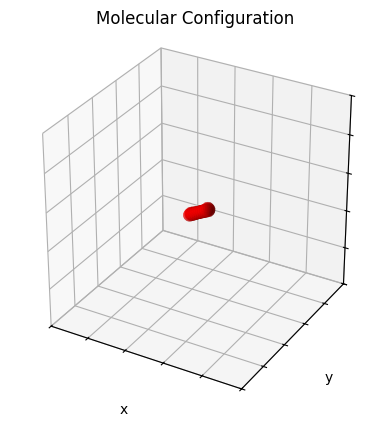

In [50]:
u = load_universe(n, a, ks[-1], epsilon_repulsives[-1], temps[3])
u.set_step(-1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u.plot(ax)

# Integration into MDAnalysis

In [12]:
import MDAnalysis as mda
import nglview as nv

In [13]:
u = mda.Universe("topology/chain0.psf", "trajectory/chain0.xyz")

In [14]:
view = nv.show_mdanalysis(u)
view

NGLWidget(max_frame=8)